# Create mask (alternate version using healsparse)

## Import libraries

In [1]:
from mocpy import MOC
import healsparse
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pyarrow as pa
from astropy.coordinates import Angle, Latitude, Longitude
from astropy.table import Table

## Constants

In [3]:
REGION_DIR = Path('.')
BOX_REGIONS = REGION_DIR / 'box.reg.I'
DIP_REGIONS = REGION_DIR / 'dip.reg.I.nodups_head'
STARS_REGIONS = REGION_DIR / 'stars.reg.I.nodups_head'
FOOT_REGIONS = REGION_DIR / 'footprint.reg'

In [2]:
HIGHEST_ORDER = 17  # Smallest tiles to start with
SPLIT_ORDER = 5  # Split building tasks into tiles of this order
DEPTH_DELTA = 3  # Specifies the precision of the healpix filtering, higher is better, lower is faster
MOCPY_THREADS = None  # Number of threads to use with mocpy

In [29]:
HSMAP_FITS = REGION_DIR / 'N17.hs'          # output mask (fits)
HSMAP_PARQ = REGION_DIR / 'N17.parquet'     # output mask (parquet dir)

## Read ascii region files and convert to healpix tiles of `HIGHEST_ORDER`

In [23]:
def read_circles_mocpy(filename):
    table = Table.read(
        filename,
        format='ascii',
        names=['ra', 'dec', 'radius'],
        units=['deg'] * 3,
    )
    ra = Longitude(table['ra'])
    dec = Latitude(table['dec'])
    radius = Angle(table['radius'])
    
    mocs = MOC.from_cones(
        lon=ra,
        lat=dec,
        radius=radius,
        max_depth=HIGHEST_ORDER,
        delta_depth=DEPTH_DELTA,
        n_threads=MOCPY_THREADS,
    )
    hp_index = np.concatenate([moc.flatten() for moc in mocs])
    return hp_index

# We use mocpy here because cdshealpix doesn't support box searches
def read_boxes(filename):
    table = Table.read(
        filename,
        format='ascii',
        names=['ra_c', 'dec_c', 'width', 'height'],
        units=['deg'] * 4
    )
    ra_center = Longitude(table['ra_c'])
    dec_center = Latitude(table['dec_c'])
    width = Angle(table['width'])
    height = Angle(table['height'])
    
    width_larger = width > height
    a = np.where(width_larger, 0.5 * width, 0.5 * height)
    b = np.where(width_larger, 0.5 * height, 0.5 * width)
    angle = np.where(width_larger, Angle(90, 'deg'), 0)
    
    mocs = MOC.from_boxes(
        lon=ra_center,
        lat=dec_center,
        a=a,
        b=b,
        angle=angle,
        max_depth=HIGHEST_ORDER,
        n_threads=MOCPY_THREADS,
    )
    hp_index = np.concatenate([moc.flatten() for moc in mocs])
    return hp_index

In [6]:
dip_index = np.unique(read_circles_mocpy(DIP_REGIONS)).astype(np.int64)
print('Dip pixels :', dip_index.shape[0])
stars_index = np.unique(read_circles_mocpy(STARS_REGIONS)).astype(np.int64)
print('Star pixels:', stars_index.shape[0])                 
box_index = np.unique(read_boxes(BOX_REGIONS)).astype(np.int64)
print('box pixels:', box_index.shape[0])  
foot_index = np.unique(read_boxes(FOOT_REGIONS)).astype(np.int64)
print('foot pixels:', foot_index.shape[0])

Dip pixels : 137471627
Star pixels: 19692974
box pixels: 416961968
foot pixels: 171574522


## Create map (boolean)

In [7]:
# Choose coverage (low) and sparse (high) resolution
nside_coverage = 2**8
nside_sparse = 2**17

# Generate blank map
hsp_map = healsparse.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.bool_, bit_packed=True)

In [8]:
# Carve the (positive) footprint
hsp_map[foot_index] = True

In [9]:
# Drill stars
hsp_map[stars_index] = False

In [10]:
# Drill boxes
hsp_map[box_index] = False

In [ ]:
# Optionally drill dips
#hsp_map[dip_index] = False

In [7]:
print(hsp_map)

HealSparseMap: nside_coverage = 256, nside_sparse = 131072, boolean bit-packed mask


In [13]:
# Write to disk in fits format
hsp_map.write(HSMAP_FITS, clobber=False)
# Optionally use parquet
#hsp_map.write(HSMAP_PARQ, format='parquet')

## Visualize

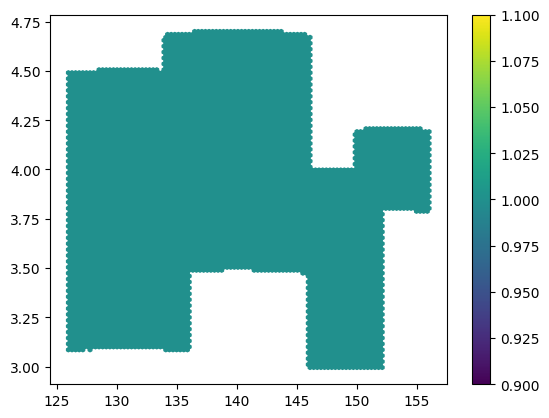

In [10]:
# Optionally visualize the map
vpix, ra, dec = hsp_map.valid_pixels_pos(return_pixels=True)
plt.hexbin(ra, dec, C=hsp_map[vpix])
#plt.xlim([152,156])
#plt.ylim([4.0,4.4])
plt.colorbar()
plt.show()

### Generate Randoms

In [11]:
# Just a few to try
ra_rand, dec_rand = healsparse.make_uniform_randoms_fast(hsp_map, 1000000)

(2.9, 4.3)

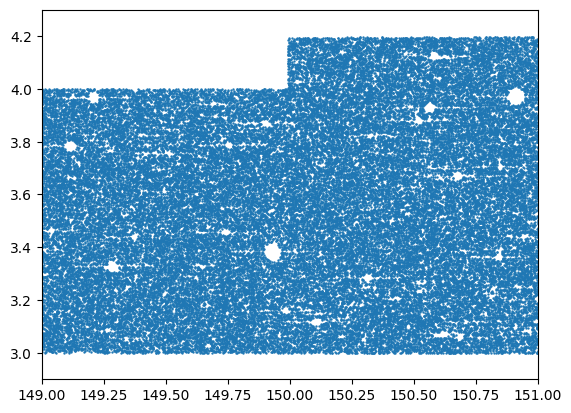

In [22]:
plt.scatter(ra_rand, dec_rand, s=0.5)
plt.xlim([149,151])
plt.ylim([2.9,4.3])

In [11]:
# Now make more rands and write to disk to visualize with topcat
nr = 3_000_000
ra_rand, dec_rand = healsparse.make_uniform_randoms_fast(hsp_map, nr)
Table([ra_rand, dec_rand]).write('ranfoot.fits', overwrite=True)

## If map is on disk, read it

In [30]:
hsp_map = healsparse.HealSparseMap.read(HSMAP_FITS)

In [36]:
hsp_map.n_valid

152785134

In [25]:
hsp_map.valid_pixels

array([ 268938741,  268938742,  268938743, ..., 1797914664, 1797914665,
       1797914666])

In [34]:
hsp_map.get_valid_area()

30.572793972238678

In [1]:
!du -h N17.hs

30M	N17.hs


# Single box mask to check the displacement against pixels (why?)

In [1]:
from mocpy import MOC
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import Angle, Latitude, Longitude, SkyCoord
from astropy.table import Table
import regions

In [2]:
# define box
ra_center = Angle(131.0, 'deg')
dec_center = Angle(3.8, 'deg')
a = Angle(5.0, 'deg')
b = Angle(0.7, 'deg')
angle = Angle(90.0, 'deg')

box = regions.RectangleSkyRegion(SkyCoord(ra_center, dec_center, frame='icrs'), 2*a, 2*b, Angle(0, 'deg'))

In [5]:
# get moc from boxes
moc_box = MOC.from_box(lon=ra_center, lat=dec_center, a=a, b=b, angle=angle, max_depth=15)
hp_index = moc_box.flatten()

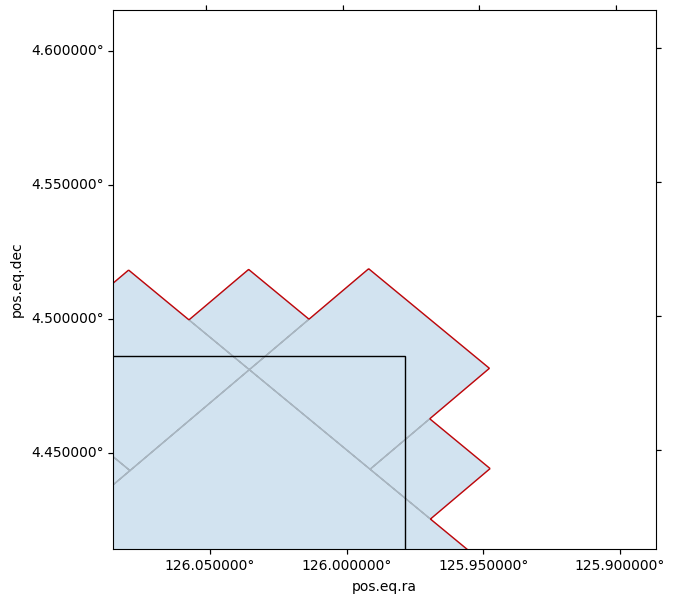

In [16]:
# plot moc and rectangle
fig = plt.figure(figsize=(7, 7))
wcs = moc_box.wcs(fig, projection='SIN')
ax = fig.add_subplot(projection=wcs)
moc_box.border(ax, wcs, color='r')
moc_box.fill(ax, wcs, alpha=0.2)
box.to_pixel(wcs).plot()
corner = [ra_center.value - a.value, dec_center.value + b.value]   # choose right-top corner
dwin = 0.1                                                         # half window size for plotting
ra_min, ra_max = corner[0]-dwin, corner[0]+dwin 
dec_min, dec_max = corner[1]-dwin, corner[1]+dwin
ax.set_xlim(wcs.wcs_world2pix(ra_max, dec_min, 1)[0], wcs.wcs_world2pix(ra_min, dec_max, 1)[0])
ax.set_ylim(wcs.wcs_world2pix(ra_max, dec_min, 1)[1], wcs.wcs_world2pix(ra_min, dec_max, 1)[1])
ax.coords['ra'].set_major_formatter('d.dddddd') ; ax.coords['dec'].set_major_formatter('d.dddddd')

In [31]:
Table([hp_index.astype(np.int64)]).write('boxmoc.fits', overwrite=True)

In [124]:
moc_box.order_to_spatial_resolution(15).dms

dms_tuple(d=0.0, m=0.0, s=6.441537022157636)

In [19]:
import healsparse

# Choose coverage (low) and sparse (high) resolution of healsparse map
nside_coverage = 2**8
nside_sparse = 2**15

# Generate blank map
hsp_map = healsparse.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.bool_, bit_packed=True)

# Carve the (positive) footprint within the rectangle
hsp_map[hp_index.astype(np.int64)] = True

In [20]:
# Make rands and write to disk to visualize with topcat
nr = 3_000_000
ra_rand, dec_rand = healsparse.make_uniform_randoms_fast(hsp_map, nr)
Table([ra_rand, dec_rand]).write('boxmoc.random.fits', overwrite=True)

# Other (dont use)

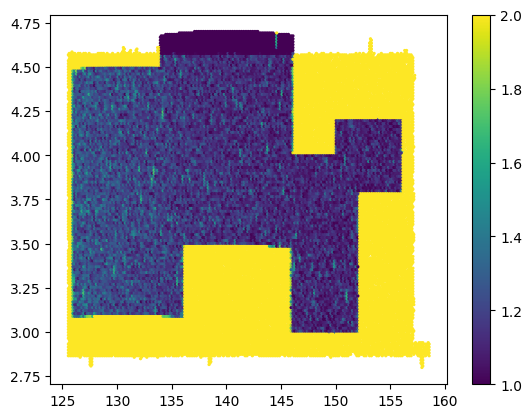

In [61]:
import healsparse
import matplotlib.pyplot as plt

nside_coverage = 2**6
nside_sparse = 2**14

# Generation of the map
hsp_map = healsparse.HealSparseMap.make_empty(nside_coverage, nside_sparse, np.int64)
hsp_map[foot_index.astype(np.int64)] = 1
hsp_map[stars_index.astype(np.int64)] = 2
#hsp_map[box_index.tolist()] = 3

# Visualization of the map
vpix, ra, dec = hsp_map.valid_pixels_pos(return_pixels=True)
plt.hexbin(ra, dec, C=hsp_map[vpix], gridsize=200)
#plt.xlim([125.5,125.9]) ; plt.ylim([4.0,4.4])
plt.colorbar()
plt.show()